#PPO



In [49]:
from google.colab import drive
drive.mount('/content/drive')

# %cd /content/drive/MyDrive
# !git clone https://github.com/openai/spinningup.git

#pip 설치
!pip install mpi4py
!pip install box2d
!pip install optuna

#py파일 참조를 위한 위치 변경
import sys
sys.path.append('/content/drive/MyDrive/Project/hanium/bipedalwalker')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####core.py 적용

In [ ]:
import importlib
import ppo.core as core
importlib.reload(core)

<module 'ppo.core' from '/content/drive/MyDrive/Project/hanium/bipedalwalker/ppo/core.py'>

#### module impot

In [54]:
from ppo import core
from utils.logx import EpochLogger
from utils.mpi_pytorch import setup_pytorch_for_mpi, sync_params, mpi_avg_grads
from utils.mpi_tools import mpi_fork, mpi_avg, proc_id, mpi_statistics_scalar, num_procs
from utils.run_utils import setup_logger_kwargs

import gym
import optuna
import math
import pygame
import random
import time
import os
import argparse
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt

####ppo main code

In [58]:
class PPOBuffer:
    def __init__(self, obs_dim, act_dim, size, gamma=0.99, lam=0.95):
        self.obs_buf = np.zeros(core.combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(core.combined_shape(size, act_dim), dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size

    def store(self, obs, act, rew, val, logp):
        """
        Append one timestep of agent-environment interaction to the buffer.
        """
        assert self.ptr < self.max_size     # buffer has to have room so you can store
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    def finish_path(self, last_val=0):
        path_slice = slice(self.path_start_idx, self.ptr)
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)

        # the next two lines implement GAE-Lambda advantage calculation
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv_buf[path_slice] = core.discount_cumsum(deltas, self.gamma * self.lam)

        # the next line computes rewards-to-go, to be targets for the value function
        self.ret_buf[path_slice] = core.discount_cumsum(rews, self.gamma)[:-1]

        self.path_start_idx = self.ptr

    def get(self):
        assert self.ptr == self.max_size    # buffer has to be full before you can get
        self.ptr, self.path_start_idx = 0, 0
        # the next two lines implement the advantage normalization trick
        adv_mean, adv_std = mpi_statistics_scalar(self.adv_buf)
        self.adv_buf = (self.adv_buf - adv_mean) / adv_std
        data = dict(obs=self.obs_buf, act=self.act_buf, ret=self.ret_buf,
                    adv=self.adv_buf, logp=self.logp_buf)
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in data.items()}


# ppo main code
def ppo(env_fn, actor_critic=core.MLPActorCritic, ac_kwargs=dict(), seed=0,
        steps_per_epoch=4000, epochs=50, gamma=0.99, clip_ratio=0.2, pi_lr=3e-4,
        vf_lr=1e-3, train_pi_iters=80, train_v_iters=80, lam=0.97, max_ep_len=1000,
        target_kl=0.01, logger_kwargs=dict(), save_freq=10):


    # Special function to avoid certain slowdowns from PyTorch + MPI combo.
    setup_pytorch_for_mpi()

    # Set up logger and save configuration
    logger = EpochLogger(**logger_kwargs)
    logger.save_config(locals())

    # Random seed
    seed += 10000 * proc_id()
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Instantiate environment
    env = env_fn()
    obs_dim = env.observation_space.shape
    act_dim = env.action_space.shape

    # Create actor-critic module
    ac = actor_critic(env.observation_space, env.action_space, **ac_kwargs)

    # Sync params across processes
    sync_params(ac)

    # Count variables
    var_counts = tuple(core.count_vars(module) for module in [ac.pi, ac.v])
    logger.log('\nNumber of parameters: \t pi: %d, \t v: %d\n'%var_counts)

    # Set up experience buffer
    local_steps_per_epoch = int(steps_per_epoch / num_procs())
    buf = PPOBuffer(obs_dim, act_dim, local_steps_per_epoch, gamma, lam)

    # Set up function for computing PPO policy loss
    def compute_loss_pi(data):
        obs, act, adv, logp_old = data['obs'], data['act'], data['adv'], data['logp']

        # Policy loss
        pi, logp = ac.pi(obs, act)
        ratio = torch.exp(logp - logp_old)
        clip_adv = torch.clamp(ratio, 1-clip_ratio, 1+clip_ratio) * adv
        loss_pi = -(torch.min(ratio * adv, clip_adv)).mean()

        # Useful extra info
        approx_kl = (logp_old - logp).mean().item()
        ent = pi.entropy().mean().item()
        clipped = ratio.gt(1+clip_ratio) | ratio.lt(1-clip_ratio)
        clipfrac = torch.as_tensor(clipped, dtype=torch.float32).mean().item()
        pi_info = dict(kl=approx_kl, ent=ent, cf=clipfrac)

        return loss_pi, pi_info

    # Set up function for computing value loss
    def compute_loss_v(data):
        obs, ret = data['obs'], data['ret']
        return ((ac.v(obs) - ret)**2).mean()

    # Set up optimizers for policy and value function
    pi_optimizer = Adam(ac.pi.parameters(), lr=pi_lr)
    vf_optimizer = Adam(ac.v.parameters(), lr=vf_lr)

    # Set up model saving
    logger.setup_pytorch_saver(ac)

    def update():
        data = buf.get()

        pi_l_old, pi_info_old = compute_loss_pi(data)
        pi_l_old = pi_l_old.item()
        v_l_old = compute_loss_v(data).item()

        # Train policy with multiple steps of gradient descent
        for i in range(train_pi_iters):
            pi_optimizer.zero_grad()
            loss_pi, pi_info = compute_loss_pi(data)
            kl = mpi_avg(pi_info['kl'])
            if kl > 1.5 * target_kl:
                logger.log('Early stopping at step %d due to reaching max kl.'%i)
                break
            loss_pi.backward()
            mpi_avg_grads(ac.pi)    # average grads across MPI processes
            pi_optimizer.step()

        logger.store(StopIter=i)

        # Value function learning
        for i in range(train_v_iters):
            vf_optimizer.zero_grad()
            loss_v = compute_loss_v(data)
            loss_v.backward()
            mpi_avg_grads(ac.v)    # average grads across MPI processes
            vf_optimizer.step()

        # Log changes from update
        kl, ent, cf = pi_info['kl'], pi_info_old['ent'], pi_info['cf']
        logger.store(LossPi=pi_l_old, LossV=v_l_old,
                     KL=kl, Entropy=ent, ClipFrac=cf,
                     DeltaLossPi=(loss_pi.item() - pi_l_old),
                     DeltaLossV=(loss_v.item() - v_l_old))

    # Prepare for interaction with environment
    start_time = time.time()
    o = env.reset()   # <-- 반드시 튜플 언패킹
    ep_ret, ep_len = 0, 0

    epoch_rewards = []
    epoch_lengths = []
    kl_vals = []
    clip_frac = []
    loss_pi = []
    loss_v = []
    entropy = []

    # Main loop: collect experience in env and update/log each epoch
    for epoch in range(epochs):
        for t in range(local_steps_per_epoch):
            a, v, logp = ac.step(torch.as_tensor(o, dtype=torch.float32))
            a = np.array(a).flatten()

            next_o, r, d, truncated = env.step(a)
            done = d or truncated
            ep_ret += r
            ep_len += 1

            # save and log
            buf.store(o, a, r, v.item(), logp)
            logger.store(VVals=v.item())

            # Update obs (critical!)
            o = next_o

            timeout = ep_len == max_ep_len
            terminal = d or timeout
            epoch_ended = t==local_steps_per_epoch-1

            if terminal or epoch_ended:
                if epoch_ended and not(terminal):
                    print('Warning: trajectory cut off by epoch at %d steps.'%ep_len, flush=True)
                # if trajectory didn't reach terminal state, bootstrap value target
                if timeout or epoch_ended:
                    _, v, _ = ac.step(torch.as_tensor(o, dtype=torch.float32))
                else:
                    v = 0
                buf.finish_path(v)
                if terminal:
                    # only save EpRet / EpLen if trajectory finished
                    logger.store(EpRet=ep_ret, EpLen=ep_len)
                o = env.reset()
                ep_ret, ep_len = 0, 0


        # Save model
        if (epoch % save_freq == 0) or (epoch == epochs-1):
            logger.save_state({'env': env}, None)

        # Perform PPO update!
        update()

        ep_ret_mean = logger.get_stats('EpRet')[0]
        ep_len_mean = logger.get_stats('EpLen')[0]
        kl_mean = logger.get_stats('KL')[0]
        ClipFrac = logger.get_stats('ClipFrac')[0]
        LossPi = logger.get_stats('LossPi')[0]
        LossV = logger.get_stats('LossV')[0]
        Entropy = logger.get_stats('Entropy')[0]

        # Log info about epoch
        logger.log_tabular('Epoch', epoch)
        logger.log_tabular('EpRet', with_min_and_max=True)
        logger.log_tabular('EpLen', average_only=True)
        logger.log_tabular('VVals', with_min_and_max=True)
        logger.log_tabular('TotalEnvInteracts', (epoch+1)*steps_per_epoch)
        logger.log_tabular('LossPi', average_only=True)
        logger.log_tabular('LossV', average_only=True)
        logger.log_tabular('DeltaLossPi', average_only=True)
        logger.log_tabular('DeltaLossV', average_only=True)
        logger.log_tabular('Entropy', average_only=True)
        logger.log_tabular('KL', average_only=True)
        logger.log_tabular('ClipFrac', average_only=True)
        logger.log_tabular('StopIter', average_only=True)
        logger.log_tabular('Time', time.time()-start_time)



        # 저장
        epoch_rewards.append(ep_ret_mean)
        epoch_lengths.append(ep_len_mean)
        kl_vals.append(kl_mean)
        clip_frac.append(ClipFrac)
        loss_pi.append(LossPi)
        loss_v.append(LossV)
        entropy.append(Entropy)

        logger.dump_tabular()
    import matplotlib.pyplot as plt

    # epoch 수 (x축)
    epochs = list(range(len(epoch_rewards)))

    # 지표 딕셔너리 구성
    metrics = {
        'Average Episode Return': epoch_rewards,
        'Episode Length': epoch_lengths,
        'KL Divergence': kl_vals,
        'Clip Fraction': clip_frac,
        'Policy Loss': loss_pi,
        'Value Loss': loss_v,
        'Entropy': entropy
    }

    # 전체 지표 플로팅
    plt.figure(figsize=(16, 10))

    for i, (title, values) in enumerate(metrics.items(), 1):
        plt.subplot(3, 3, i)
        plt.plot(epochs, values, marker='o', linewidth=2)
        plt.title(title)
        plt.xlabel('Epoch')
        plt.grid(True)

    plt.tight_layout()
    plt.show()


In [63]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--env', type=str, default='BipedalWalker-v3')
    parser.add_argument('--hid', type=int, default=64)
    parser.add_argument('--l', type=int, default=2)
    parser.add_argument('--gamma', type=float, default=0.999)
    parser.add_argument('--seed', '-s', type=int, default=0)
    parser.add_argument('--cpu', type=int, default=1)
    parser.add_argument('--steps', type=int, default=2048)
    parser.add_argument('--epochs', type=int, default=320)
    parser.add_argument('--exp_name', type=str, default='ppo')

    args, unknown = parser.parse_known_args()
    return args

Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/ppo/ppo_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            64,
            64
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "clip_ratio":	0.2,
    "env_fn":	"<function <lambda> at 0x7f1d4c1ccd60>",
    "epochs":	320,
    "exp_name":	"ppo",
    "gamma":	0.999,
    "lam":	0.97,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7f1d4d6ef410>":	{
            "epoch_dict":	{},
            "exp_name":	"ppo",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/ppo/ppo_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/ppo/ppo_s0/progress.txt' mode='w' encoding='utf-8'>":	{
                    "mode":	"w"
                }
            }
        }
    }

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


---------------------------------------
|             Epoch |               0 |
|      AverageEpRet |           -50.3 |
|          StdEpRet |            2.75 |
|          MaxEpRet |           -47.6 |
|          MinEpRet |           -53.1 |
|             EpLen |           1e+03 |
|      AverageVVals |         -0.0469 |
|          StdVVals |          0.0905 |
|          MaxVVals |           0.265 |
|          MinVVals |          -0.284 |
| TotalEnvInteracts |        2.05e+03 |
|            LossPi |        5.29e-08 |
|             LossV |             393 |
|       DeltaLossPi |           -0.02 |
|        DeltaLossV |            -239 |
|           Entropy |           0.919 |
|                KL |          0.0105 |
|          ClipFrac |           0.138 |
|          StopIter |              79 |
|              Time |            2.13 |
---------------------------------------


/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |           -83.8 |
|          StdEpRet |            22.1 |
|          MaxEpRet |           -61.7 |
|          MinEpRet |            -106 |
|             EpLen |             548 |
|      AverageVVals |           -8.64 |
|          StdVVals |           0.897 |
|          MaxVVals |           -4.04 |
|          MinVVals |           -9.49 |
| TotalEnvInteracts |         4.1e+03 |
|            LossPi |           1e-08 |
|             LossV |             761 |
|       DeltaLossPi |         -0.0209 |
|        DeltaLossV |            -273 |
|           Entropy |           0.905 |
|                KL |          0.0121 |
|          ClipFrac |           0.229 |
|          StopIter |              79 |
|              Time |            4.24 |
---------------------------------------
Early stopping at step 8 due to reaching max kl.
---------------------------------------
|             Epoch |          

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


---------------------------------------
|             Epoch |              11 |
|      AverageEpRet |           -46.2 |
|          StdEpRet |            6.16 |
|          MaxEpRet |           -40.1 |
|          MinEpRet |           -52.4 |
|             EpLen |           1e+03 |
|      AverageVVals |           -64.2 |
|          StdVVals |           0.011 |
|          MaxVVals |           -64.1 |
|          MinVVals |           -64.2 |
| TotalEnvInteracts |        2.46e+04 |
|            LossPi |        3.26e-08 |
|             LossV |            54.8 |
|       DeltaLossPi |         -0.0239 |
|        DeltaLossV |           -12.7 |
|           Entropy |           0.912 |
|                KL |          0.0115 |
|          ClipFrac |           0.169 |
|          StopIter |              79 |
|              Time |            24.3 |
---------------------------------------
---------------------------------------
|             Epoch |              12 |
|      AverageEpRet |            -101 |


/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


---------------------------------------
|             Epoch |              21 |
|      AverageEpRet |            -105 |
|          StdEpRet |            22.6 |
|          MaxEpRet |           -50.3 |
|          MinEpRet |            -120 |
|             EpLen |             219 |
|      AverageVVals |           -59.2 |
|          StdVVals |            7.91 |
|          MaxVVals |           -48.7 |
|          MinVVals |             -71 |
| TotalEnvInteracts |        4.51e+04 |
|            LossPi |       -1.89e-08 |
|             LossV |             322 |
|       DeltaLossPi |         -0.0188 |
|        DeltaLossV |           -73.3 |
|           Entropy |           0.918 |
|                KL |          0.0109 |
|          ClipFrac |           0.147 |
|          StopIter |              79 |
|              Time |            44.6 |
---------------------------------------
Early stopping at step 5 due to reaching max kl.
---------------------------------------
|             Epoch |          

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 20 due to reaching max kl.
---------------------------------------
|             Epoch |              31 |
|      AverageEpRet |             -72 |
|          StdEpRet |            28.5 |
|          MaxEpRet |           -43.5 |
|          MinEpRet |            -101 |
|             EpLen |             534 |
|      AverageVVals |           -44.4 |
|          StdVVals |            2.14 |
|          MaxVVals |           -42.7 |
|          MinVVals |           -77.5 |
| TotalEnvInteracts |        6.55e+04 |
|            LossPi |       -7.68e-09 |
|             LossV |            67.5 |
|       DeltaLossPi |         -0.0149 |
|        DeltaLossV |           -53.9 |
|           Entropy |            0.89 |
|                KL |          0.0153 |
|          ClipFrac |           0.193 |
|          StopIter |              20 |
|              Time |            65.3 |
---------------------------------------
---------------------------------------
|             Epoch |         

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 5 due to reaching max kl.
---------------------------------------
|             Epoch |              41 |
|      AverageEpRet |           -31.5 |
|          StdEpRet |             2.7 |
|          MaxEpRet |           -28.8 |
|          MinEpRet |           -34.2 |
|             EpLen |           1e+03 |
|      AverageVVals |           -34.4 |
|          StdVVals |            1.19 |
|          MaxVVals |           -28.4 |
|          MinVVals |           -36.2 |
| TotalEnvInteracts |         8.6e+04 |
|            LossPi |        1.35e-08 |
|             LossV |            8.37 |
|       DeltaLossPi |        -0.00328 |
|        DeltaLossV |            -6.4 |
|           Entropy |            0.84 |
|                KL |           0.016 |
|          ClipFrac |           0.204 |
|          StopIter |               5 |
|              Time |            85.4 |
---------------------------------------
---------------------------------------
|             Epoch |          

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


---------------------------------------
|             Epoch |              51 |
|      AverageEpRet |           -29.6 |
|          StdEpRet |           0.566 |
|          MaxEpRet |             -29 |
|          MinEpRet |           -30.1 |
|             EpLen |           1e+03 |
|      AverageVVals |           -31.8 |
|          StdVVals |         0.00687 |
|          MaxVVals |           -31.8 |
|          MinVVals |           -32.1 |
| TotalEnvInteracts |        1.06e+05 |
|            LossPi |       -1.42e-08 |
|             LossV |            1.51 |
|       DeltaLossPi |         -0.0233 |
|        DeltaLossV |           -0.44 |
|           Entropy |           0.819 |
|                KL |         0.00983 |
|          ClipFrac |           0.172 |
|          StopIter |              79 |
|              Time |             106 |
---------------------------------------
---------------------------------------
|             Epoch |              52 |
|      AverageEpRet |           -24.4 |


/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


---------------------------------------
|             Epoch |              61 |
|      AverageEpRet |            14.7 |
|          StdEpRet |             1.9 |
|          MaxEpRet |            16.6 |
|          MinEpRet |            12.8 |
|             EpLen |           1e+03 |
|      AverageVVals |           -1.46 |
|          StdVVals |           0.701 |
|          MaxVVals |            3.49 |
|          MinVVals |           -11.7 |
| TotalEnvInteracts |        1.27e+05 |
|            LossPi |       -2.31e-08 |
|             LossV |            52.5 |
|       DeltaLossPi |           -0.02 |
|        DeltaLossV |           -40.6 |
|           Entropy |           0.743 |
|                KL |         0.00682 |
|          ClipFrac |           0.147 |
|          StopIter |              79 |
|              Time |             126 |
---------------------------------------
Early stopping at step 4 due to reaching max kl.
---------------------------------------
|             Epoch |          

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 5 due to reaching max kl.
---------------------------------------
|             Epoch |              71 |
|      AverageEpRet |            58.4 |
|          StdEpRet |            6.34 |
|          MaxEpRet |            64.7 |
|          MinEpRet |              52 |
|             EpLen |           1e+03 |
|      AverageVVals |            39.9 |
|          StdVVals |            1.65 |
|          MaxVVals |            40.1 |
|          MinVVals |           -8.56 |
| TotalEnvInteracts |        1.47e+05 |
|            LossPi |        9.31e-09 |
|             LossV |             114 |
|       DeltaLossPi |        -0.00869 |
|        DeltaLossV |           -77.1 |
|           Entropy |           0.723 |
|                KL |          0.0163 |
|          ClipFrac |           0.159 |
|          StopIter |               5 |
|              Time |             145 |
---------------------------------------
---------------------------------------
|             Epoch |          

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 27 due to reaching max kl.
---------------------------------------
|             Epoch |              81 |
|      AverageEpRet |           -44.2 |
|          StdEpRet |            78.9 |
|          MaxEpRet |            74.7 |
|          MinEpRet |            -124 |
|             EpLen |             500 |
|      AverageVVals |            4.57 |
|          StdVVals |            14.4 |
|          MaxVVals |            8.48 |
|          MinVVals |           -72.4 |
| TotalEnvInteracts |        1.68e+05 |
|            LossPi |        1.35e-08 |
|             LossV |        1.97e+03 |
|       DeltaLossPi |         -0.0207 |
|        DeltaLossV |            -317 |
|           Entropy |           0.723 |
|                KL |          0.0151 |
|          ClipFrac |           0.219 |
|          StopIter |              27 |
|              Time |             164 |
---------------------------------------
Early stopping at step 4 due to reaching max kl.
---------------------

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 4 due to reaching max kl.
---------------------------------------
|             Epoch |              91 |
|      AverageEpRet |            63.8 |
|          StdEpRet |            6.47 |
|          MaxEpRet |            70.3 |
|          MinEpRet |            57.3 |
|             EpLen |           1e+03 |
|      AverageVVals |              48 |
|          StdVVals |           0.142 |
|          MaxVVals |            48.1 |
|          MinVVals |            44.6 |
| TotalEnvInteracts |        1.88e+05 |
|            LossPi |       -7.33e-09 |
|             LossV |            68.4 |
|       DeltaLossPi |        -0.00438 |
|        DeltaLossV |           -26.6 |
|           Entropy |           0.657 |
|                KL |          0.0183 |
|          ClipFrac |           0.169 |
|          StopIter |               4 |
|              Time |             183 |
---------------------------------------
Early stopping at step 4 due to reaching max kl.
----------------------

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 4 due to reaching max kl.
---------------------------------------
|             Epoch |             101 |
|      AverageEpRet |            49.7 |
|          StdEpRet |         0.00327 |
|          MaxEpRet |            49.7 |
|          MinEpRet |            49.7 |
|             EpLen |           1e+03 |
|      AverageVVals |              50 |
|          StdVVals |            1.49 |
|          MaxVVals |            54.3 |
|          MinVVals |            36.3 |
| TotalEnvInteracts |        2.09e+05 |
|            LossPi |        2.47e-08 |
|             LossV |            9.87 |
|       DeltaLossPi |        -0.00395 |
|        DeltaLossV |           -1.67 |
|           Entropy |           0.639 |
|                KL |           0.018 |
|          ClipFrac |           0.296 |
|          StopIter |               4 |
|              Time |             203 |
---------------------------------------
Early stopping at step 13 due to reaching max kl.
---------------------

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 2 due to reaching max kl.
---------------------------------------
|             Epoch |             111 |
|      AverageEpRet |              79 |
|          StdEpRet |           0.832 |
|          MaxEpRet |            79.8 |
|          MinEpRet |            78.2 |
|             EpLen |           1e+03 |
|      AverageVVals |            75.2 |
|          StdVVals |           0.638 |
|          MaxVVals |              79 |
|          MinVVals |            67.5 |
| TotalEnvInteracts |        2.29e+05 |
|            LossPi |        1.77e-08 |
|             LossV |            25.7 |
|       DeltaLossPi |        -0.00439 |
|        DeltaLossV |           -6.26 |
|           Entropy |           0.611 |
|                KL |          0.0172 |
|          ClipFrac |           0.261 |
|          StopIter |               2 |
|              Time |             222 |
---------------------------------------
Early stopping at step 8 due to reaching max kl.
----------------------

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


---------------------------------------
|             Epoch |             121 |
|      AverageEpRet |            82.2 |
|          StdEpRet |             2.2 |
|          MaxEpRet |            84.4 |
|          MinEpRet |              80 |
|             EpLen |           1e+03 |
|      AverageVVals |            67.4 |
|          StdVVals |            1.66 |
|          MaxVVals |            71.4 |
|          MinVVals |            63.2 |
| TotalEnvInteracts |         2.5e+05 |
|            LossPi |        2.96e-08 |
|             LossV |            53.2 |
|       DeltaLossPi |         -0.0219 |
|        DeltaLossV |           -31.4 |
|           Entropy |           0.577 |
|                KL |          0.0144 |
|          ClipFrac |           0.167 |
|          StopIter |              79 |
|              Time |             241 |
---------------------------------------
Early stopping at step 3 due to reaching max kl.
---------------------------------------
|             Epoch |          

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 7 due to reaching max kl.
---------------------------------------
|             Epoch |             131 |
|      AverageEpRet |            72.2 |
|          StdEpRet |            3.64 |
|          MaxEpRet |            75.9 |
|          MinEpRet |            68.6 |
|             EpLen |           1e+03 |
|      AverageVVals |            89.8 |
|          StdVVals |           0.776 |
|          MaxVVals |              90 |
|          MinVVals |              79 |
| TotalEnvInteracts |         2.7e+05 |
|            LossPi |       -2.68e-09 |
|             LossV |            49.9 |
|       DeltaLossPi |        -0.00792 |
|        DeltaLossV |           -18.7 |
|           Entropy |           0.577 |
|                KL |          0.0154 |
|          ClipFrac |           0.156 |
|          StopIter |               7 |
|              Time |             260 |
---------------------------------------
---------------------------------------
|             Epoch |          

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 15 due to reaching max kl.
---------------------------------------
|             Epoch |             141 |
|      AverageEpRet |           -5.82 |
|          StdEpRet |            69.2 |
|          MaxEpRet |            63.4 |
|          MinEpRet |             -75 |
|             EpLen |             760 |
|      AverageVVals |            70.1 |
|          StdVVals |            20.5 |
|          MaxVVals |            77.7 |
|          MinVVals |           -60.3 |
| TotalEnvInteracts |        2.91e+05 |
|            LossPi |        2.89e-08 |
|             LossV |        4.73e+03 |
|       DeltaLossPi |         -0.0181 |
|        DeltaLossV |       -1.74e+03 |
|           Entropy |           0.517 |
|                KL |          0.0171 |
|          ClipFrac |           0.226 |
|          StopIter |              15 |
|              Time |             280 |
---------------------------------------
---------------------------------------
|             Epoch |         

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 9 due to reaching max kl.
---------------------------------------
|             Epoch |             151 |
|      AverageEpRet |            82.1 |
|          StdEpRet |            2.09 |
|          MaxEpRet |            84.2 |
|          MinEpRet |              80 |
|             EpLen |           1e+03 |
|      AverageVVals |            55.6 |
|          StdVVals |            2.09 |
|          MaxVVals |            69.8 |
|          MinVVals |            25.2 |
| TotalEnvInteracts |        3.11e+05 |
|            LossPi |       -4.66e-10 |
|             LossV |             153 |
|       DeltaLossPi |        -0.00928 |
|        DeltaLossV |            -106 |
|           Entropy |           0.485 |
|                KL |          0.0173 |
|          ClipFrac |           0.216 |
|          StopIter |               9 |
|              Time |             299 |
---------------------------------------
---------------------------------------
|             Epoch |          

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


---------------------------------------
|             Epoch |             161 |
|      AverageEpRet |            60.2 |
|          StdEpRet |            8.77 |
|          MaxEpRet |              69 |
|          MinEpRet |            51.4 |
|             EpLen |           1e+03 |
|      AverageVVals |              68 |
|          StdVVals |            5.32 |
|          MaxVVals |            76.8 |
|          MinVVals |            8.45 |
| TotalEnvInteracts |        3.32e+05 |
|            LossPi |        3.45e-08 |
|             LossV |            54.2 |
|       DeltaLossPi |         -0.0195 |
|        DeltaLossV |           -20.9 |
|           Entropy |           0.456 |
|                KL |          0.0131 |
|          ClipFrac |           0.173 |
|          StopIter |              79 |
|              Time |             318 |
---------------------------------------
---------------------------------------
|             Epoch |             162 |
|      AverageEpRet |            73.2 |


/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 4 due to reaching max kl.
---------------------------------------
|             Epoch |             171 |
|      AverageEpRet |            10.1 |
|          StdEpRet |            90.3 |
|          MaxEpRet |             100 |
|          MinEpRet |           -80.2 |
|             EpLen |             652 |
|      AverageVVals |            67.2 |
|          StdVVals |            19.7 |
|          MaxVVals |              80 |
|          MinVVals |           -70.1 |
| TotalEnvInteracts |        3.52e+05 |
|            LossPi |        2.61e-08 |
|             LossV |        2.77e+03 |
|       DeltaLossPi |          -0.007 |
|        DeltaLossV |            -321 |
|           Entropy |           0.416 |
|                KL |          0.0198 |
|          ClipFrac |           0.193 |
|          StopIter |               4 |
|              Time |             338 |
---------------------------------------
Early stopping at step 3 due to reaching max kl.
----------------------

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


---------------------------------------
|             Epoch |             181 |
|      AverageEpRet |            77.8 |
|          StdEpRet |            2.27 |
|          MaxEpRet |            80.1 |
|          MinEpRet |            75.5 |
|             EpLen |           1e+03 |
|      AverageVVals |            73.3 |
|          StdVVals |            1.26 |
|          MaxVVals |            78.9 |
|          MinVVals |              63 |
| TotalEnvInteracts |        3.73e+05 |
|            LossPi |        3.03e-09 |
|             LossV |            17.2 |
|       DeltaLossPi |         -0.0263 |
|        DeltaLossV |            -2.1 |
|           Entropy |           0.403 |
|                KL |         0.00777 |
|          ClipFrac |            0.16 |
|          StopIter |              79 |
|              Time |             357 |
---------------------------------------
Early stopping at step 17 due to reaching max kl.
---------------------------------------
|             Epoch |         

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 3 due to reaching max kl.
---------------------------------------
|             Epoch |             191 |
|      AverageEpRet |            96.8 |
|          StdEpRet |            5.11 |
|          MaxEpRet |             102 |
|          MinEpRet |            91.7 |
|             EpLen |           1e+03 |
|      AverageVVals |            88.4 |
|          StdVVals |            15.5 |
|          MaxVVals |            93.4 |
|          MinVVals |           -71.8 |
| TotalEnvInteracts |        3.93e+05 |
|            LossPi |        9.78e-09 |
|             LossV |             309 |
|       DeltaLossPi |         -0.0023 |
|        DeltaLossV |            -286 |
|           Entropy |           0.366 |
|                KL |          0.0237 |
|          ClipFrac |           0.277 |
|          StopIter |               3 |
|              Time |             376 |
---------------------------------------
Early stopping at step 2 due to reaching max kl.
----------------------

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


---------------------------------------
|             Epoch |             201 |
|      AverageEpRet |             113 |
|          StdEpRet |            1.44 |
|          MaxEpRet |             114 |
|          MinEpRet |             111 |
|             EpLen |           1e+03 |
|      AverageVVals |             109 |
|          StdVVals |            0.56 |
|          MaxVVals |             109 |
|          MinVVals |             102 |
| TotalEnvInteracts |        4.14e+05 |
|            LossPi |       -1.46e-08 |
|             LossV |            20.2 |
|       DeltaLossPi |         -0.0265 |
|        DeltaLossV |           -11.6 |
|           Entropy |           0.342 |
|                KL |          0.0109 |
|          ClipFrac |           0.165 |
|          StopIter |              79 |
|              Time |             395 |
---------------------------------------
---------------------------------------
|             Epoch |             202 |
|      AverageEpRet |             112 |


/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 7 due to reaching max kl.
---------------------------------------
|             Epoch |             211 |
|      AverageEpRet |            96.2 |
|          StdEpRet |           0.178 |
|          MaxEpRet |            96.3 |
|          MinEpRet |              96 |
|             EpLen |           1e+03 |
|      AverageVVals |            71.1 |
|          StdVVals |            5.71 |
|          MaxVVals |            80.8 |
|          MinVVals |            30.9 |
| TotalEnvInteracts |        4.34e+05 |
|            LossPi |       -5.01e-09 |
|             LossV |             214 |
|       DeltaLossPi |        -0.00824 |
|        DeltaLossV |            -165 |
|           Entropy |           0.305 |
|                KL |          0.0162 |
|          ClipFrac |           0.122 |
|          StopIter |               7 |
|              Time |             414 |
---------------------------------------
Early stopping at step 8 due to reaching max kl.
----------------------

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 5 due to reaching max kl.
---------------------------------------
|             Epoch |             221 |
|      AverageEpRet |             133 |
|          StdEpRet |            5.13 |
|          MaxEpRet |             138 |
|          MinEpRet |             128 |
|             EpLen |           1e+03 |
|      AverageVVals |             100 |
|          StdVVals |            2.83 |
|          MaxVVals |             111 |
|          MinVVals |            62.6 |
| TotalEnvInteracts |        4.55e+05 |
|            LossPi |       -1.07e-08 |
|             LossV |             246 |
|       DeltaLossPi |           -0.01 |
|        DeltaLossV |            -186 |
|           Entropy |           0.276 |
|                KL |          0.0152 |
|          ClipFrac |           0.202 |
|          StopIter |               5 |
|              Time |             433 |
---------------------------------------
Early stopping at step 2 due to reaching max kl.
----------------------

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 8 due to reaching max kl.
---------------------------------------
|             Epoch |             231 |
|      AverageEpRet |            15.4 |
|          StdEpRet |             104 |
|          MaxEpRet |             119 |
|          MinEpRet |           -88.6 |
|             EpLen |             644 |
|      AverageVVals |             110 |
|          StdVVals |            30.2 |
|          MaxVVals |             119 |
|          MinVVals |           -81.1 |
| TotalEnvInteracts |        4.75e+05 |
|            LossPi |        6.87e-09 |
|             LossV |        4.34e+03 |
|       DeltaLossPi |        -0.00913 |
|        DeltaLossV |            -961 |
|           Entropy |           0.262 |
|                KL |          0.0163 |
|          ClipFrac |           0.221 |
|          StopIter |               8 |
|              Time |             452 |
---------------------------------------
Early stopping at step 8 due to reaching max kl.
----------------------

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 7 due to reaching max kl.
---------------------------------------
|             Epoch |             241 |
|      AverageEpRet |             130 |
|          StdEpRet |            4.35 |
|          MaxEpRet |             134 |
|          MinEpRet |             125 |
|             EpLen |           1e+03 |
|      AverageVVals |             117 |
|          StdVVals |            1.04 |
|          MaxVVals |             122 |
|          MinVVals |             111 |
| TotalEnvInteracts |        4.96e+05 |
|            LossPi |        2.12e-08 |
|             LossV |            56.6 |
|       DeltaLossPi |        -0.00924 |
|        DeltaLossV |           -27.8 |
|           Entropy |           0.233 |
|                KL |          0.0152 |
|          ClipFrac |           0.119 |
|          StopIter |               7 |
|              Time |             471 |
---------------------------------------
Early stopping at step 4 due to reaching max kl.
----------------------

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


---------------------------------------
|             Epoch |             251 |
|      AverageEpRet |             141 |
|          StdEpRet |            3.75 |
|          MaxEpRet |             144 |
|          MinEpRet |             137 |
|             EpLen |           1e+03 |
|      AverageVVals |             132 |
|          StdVVals |           0.445 |
|          MaxVVals |             132 |
|          MinVVals |             126 |
| TotalEnvInteracts |        5.16e+05 |
|            LossPi |        5.33e-08 |
|             LossV |            59.8 |
|       DeltaLossPi |         -0.0243 |
|        DeltaLossV |           -27.4 |
|           Entropy |           0.218 |
|                KL |          0.0133 |
|          ClipFrac |            0.15 |
|          StopIter |              79 |
|              Time |             491 |
---------------------------------------
Early stopping at step 5 due to reaching max kl.
---------------------------------------
|             Epoch |          

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 4 due to reaching max kl.
---------------------------------------
|             Epoch |             261 |
|      AverageEpRet |             162 |
|          StdEpRet |            3.21 |
|          MaxEpRet |             165 |
|          MinEpRet |             159 |
|             EpLen |           1e+03 |
|      AverageVVals |             109 |
|          StdVVals |            21.6 |
|          MaxVVals |             130 |
|          MinVVals |           -82.6 |
| TotalEnvInteracts |        5.37e+05 |
|            LossPi |       -1.09e-08 |
|             LossV |             886 |
|       DeltaLossPi |        -0.00506 |
|        DeltaLossV |            -540 |
|           Entropy |           0.202 |
|                KL |          0.0208 |
|          ClipFrac |           0.249 |
|          StopIter |               4 |
|              Time |             510 |
---------------------------------------
Early stopping at step 15 due to reaching max kl.
---------------------

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 49 due to reaching max kl.
---------------------------------------
|             Epoch |             271 |
|      AverageEpRet |             180 |
|          StdEpRet |            8.26 |
|          MaxEpRet |             189 |
|          MinEpRet |             172 |
|             EpLen |           1e+03 |
|      AverageVVals |             150 |
|          StdVVals |            2.13 |
|          MaxVVals |             154 |
|          MinVVals |             138 |
| TotalEnvInteracts |        5.57e+05 |
|            LossPi |        -2.4e-08 |
|             LossV |             296 |
|       DeltaLossPi |         -0.0237 |
|        DeltaLossV |            -208 |
|           Entropy |           0.191 |
|                KL |           0.015 |
|          ClipFrac |            0.18 |
|          StopIter |              49 |
|              Time |             530 |
---------------------------------------
---------------------------------------
|             Epoch |         

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


---------------------------------------
|             Epoch |             281 |
|      AverageEpRet |             174 |
|          StdEpRet |            6.72 |
|          MaxEpRet |             180 |
|          MinEpRet |             167 |
|             EpLen |           1e+03 |
|      AverageVVals |             173 |
|          StdVVals |           0.463 |
|          MaxVVals |             173 |
|          MinVVals |             165 |
| TotalEnvInteracts |        5.78e+05 |
|            LossPi |        2.96e-08 |
|             LossV |            18.6 |
|       DeltaLossPi |         -0.0265 |
|        DeltaLossV |           -4.44 |
|           Entropy |           0.187 |
|                KL |          0.0063 |
|          ClipFrac |           0.124 |
|          StopIter |              79 |
|              Time |             549 |
---------------------------------------
Early stopping at step 26 due to reaching max kl.
---------------------------------------
|             Epoch |         

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


---------------------------------------
|             Epoch |             291 |
|      AverageEpRet |             179 |
|          StdEpRet |            7.33 |
|          MaxEpRet |             186 |
|          MinEpRet |             171 |
|             EpLen |           1e+03 |
|      AverageVVals |             174 |
|          StdVVals |           0.777 |
|          MaxVVals |             174 |
|          MinVVals |             165 |
| TotalEnvInteracts |        5.98e+05 |
|            LossPi |        -2.2e-08 |
|             LossV |            39.1 |
|       DeltaLossPi |         -0.0268 |
|        DeltaLossV |           -15.5 |
|           Entropy |           0.109 |
|                KL |          0.0138 |
|          ClipFrac |           0.132 |
|          StopIter |              79 |
|              Time |             569 |
---------------------------------------
Early stopping at step 2 due to reaching max kl.
---------------------------------------
|             Epoch |          

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 20 due to reaching max kl.
---------------------------------------
|             Epoch |             301 |
|      AverageEpRet |             174 |
|          StdEpRet |            12.7 |
|          MaxEpRet |             186 |
|          MinEpRet |             161 |
|             EpLen |           1e+03 |
|      AverageVVals |             182 |
|          StdVVals |            0.95 |
|          MaxVVals |             182 |
|          MinVVals |             172 |
| TotalEnvInteracts |        6.18e+05 |
|            LossPi |       -6.98e-09 |
|             LossV |            36.6 |
|       DeltaLossPi |         -0.0164 |
|        DeltaLossV |          -0.775 |
|           Entropy |          0.0956 |
|                KL |          0.0156 |
|          ClipFrac |           0.175 |
|          StopIter |              20 |
|              Time |             588 |
---------------------------------------
Early stopping at step 12 due to reaching max kl.
--------------------

/tmp/ipython-input-58-152341579.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


---------------------------------------
|             Epoch |             311 |
|      AverageEpRet |             175 |
|          StdEpRet |            1.26 |
|          MaxEpRet |             176 |
|          MinEpRet |             174 |
|             EpLen |           1e+03 |
|      AverageVVals |             181 |
|          StdVVals |           0.525 |
|          MaxVVals |             181 |
|          MinVVals |             174 |
| TotalEnvInteracts |        6.39e+05 |
|            LossPi |        -1.3e-08 |
|             LossV |            14.8 |
|       DeltaLossPi |         -0.0276 |
|        DeltaLossV |         -0.0463 |
|           Entropy |          0.0596 |
|                KL |           0.014 |
|          ClipFrac |           0.162 |
|          StopIter |              79 |
|              Time |             607 |
---------------------------------------
Early stopping at step 3 due to reaching max kl.
---------------------------------------
|             Epoch |          

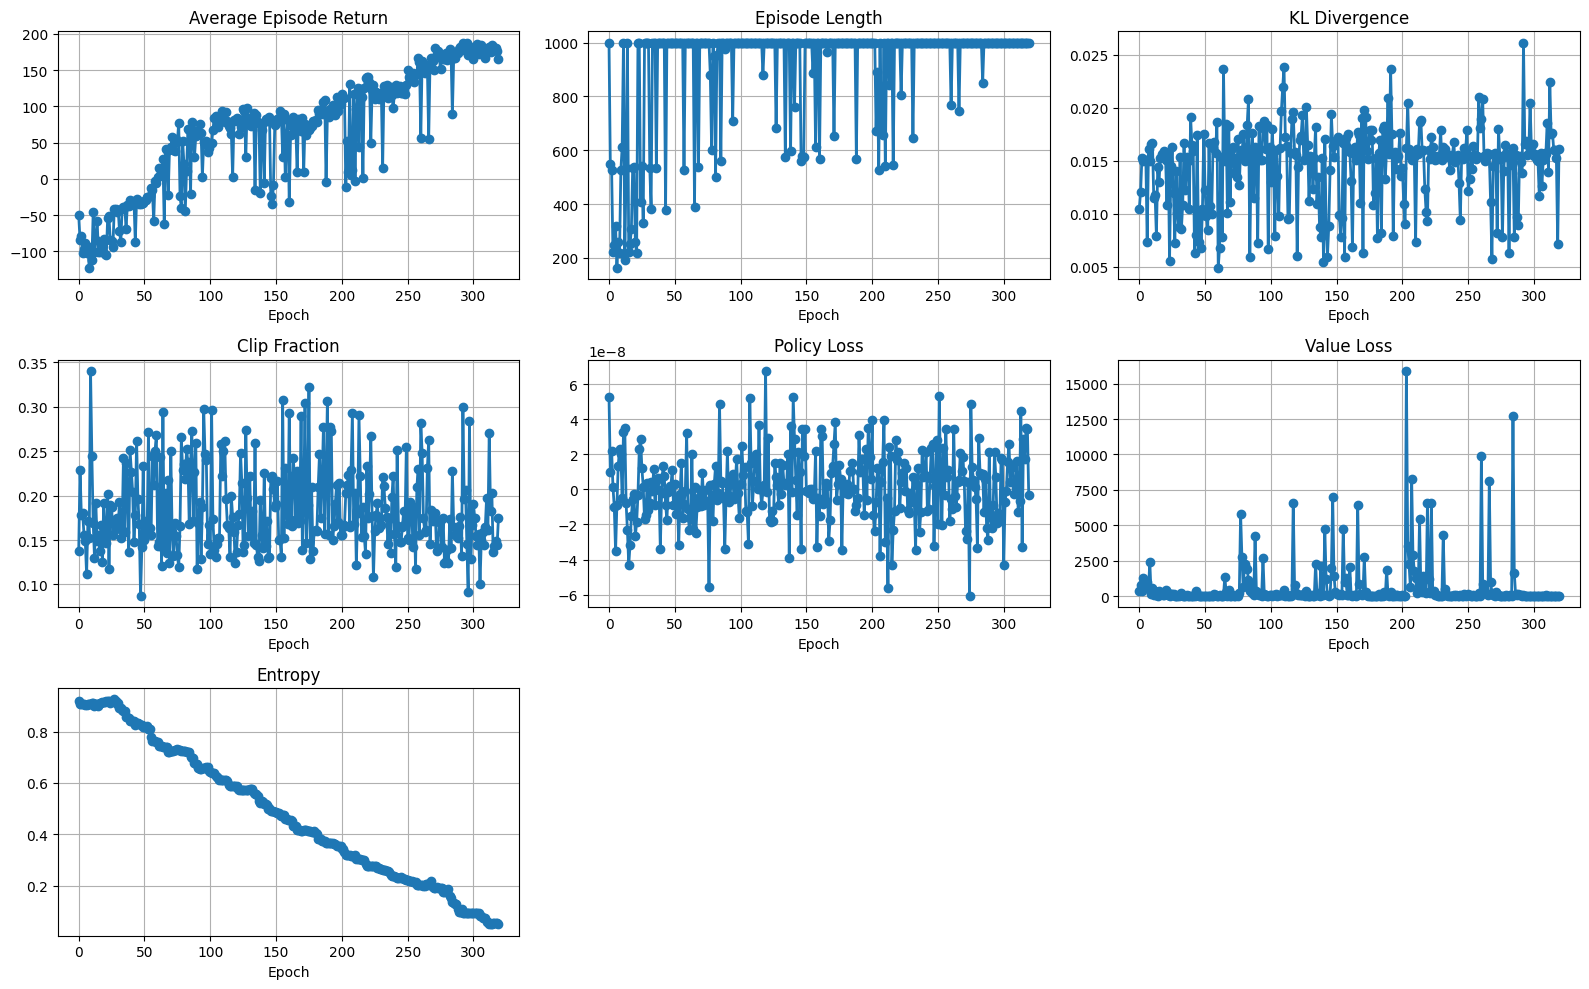

In [64]:
if __name__ == '__main__':
    args = parse_args()

    #mpi_fork(args.cpu)  # run parallel code with mpi
    logger_kwargs = setup_logger_kwargs(args.exp_name, args.seed)

    ppo(lambda : gym.make(args.env), actor_critic=core.MLPActorCritic,
        ac_kwargs=dict(hidden_sizes=[args.hid]*args.l), gamma=args.gamma,
        seed=args.seed, steps_per_epoch=args.steps, epochs=args.epochs,
        logger_kwargs=logger_kwargs)

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Project/hanium/bipedalwalker')

In [47]:
import importlib
import ppo.ppo
importlib.reload(ppo.ppo)

<module 'ppo.ppo' from '/content/drive/MyDrive/Project/hanium/bipedalwalker/ppo/ppo.py'>

In [65]:
import optuna
from ppo.ppo import ppo   # 학습 함수 직접 불러오기
import gym
from utils.run_utils import setup_logger_kwargs
from ppo import core

def objective(trial):
    # Optuna 튜닝 대상
    gamma = trial.suggest_categorical("gamma", [0.95, 0.99, 0.995, 0.999])
    hid = trial.suggest_categorical("hid", [64, 128, 256])
    l = trial.suggest_categorical("l", [1, 2, 3])
    steps = trial.suggest_categorical("steps", [2048, 4096, 8192])

    # 로거 설정 등
    from utils.logx import EpochLogger
    logger_kwargs = setup_logger_kwargs(f"trial_{trial.number}", seed=0)

    # 환경 및 actor 생성
    env_fn = lambda: gym.make("BipedalWalker-v3")
    ac_kwargs = dict(hidden_sizes=[hid]*l)

    # ppo 실행
    result = ppo(env_fn, actor_critic=core.MLPActorCritic,
                 ac_kwargs=ac_kwargs, gamma=gamma, steps_per_epoch=steps,
                 epochs=30, logger_kwargs=logger_kwargs, seed=0)

    # ppo 내부에서 마지막 reward 값을 반환하도록 해야 함
    return result  # 예: 평균 reward 등

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best params:", study.best_params)

[I 2025-07-11 11:19:39,413] A new study created in memory with name: no-name-e1ea6eb4-780d-4c51-82cc-a44452868c9f
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/content/drive/MyDrive/Project/hanium/bipedalwalker/ppo/ppo.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.2

Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_0/trial_0_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            128,
            128
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "clip_ratio":	0.2,
    "env_fn":	"<function objective.<locals>.<lambda> at 0x7f1d4c210ae0>",
    "epochs":	30,
    "exp_name":	"trial_0",
    "gamma":	0.999,
    "lam":	0.97,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7f1d4d72a2d0>":	{
            "epoch_dict":	{},
            "exp_name":	"trial_0",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_0/trial_0_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_0/trial_0_s0/progress.txt' mode='w' encoding='utf-8'>":	{
                    "mode":

[I 2025-07-11 11:19:41,568] Trial 0 finished with value: -72.1905517578125 and parameters: {'gamma': 0.999, 'hid': 128, 'l': 2, 'steps': 2048}. Best is trial 0 with value: -72.1905517578125.


Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_1/trial_1_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            128
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "clip_ratio":	0.2,
    "env_fn":	"<function objective.<locals>.<lambda> at 0x7f1d3b18fce0>",
    "epochs":	30,
    "exp_name":	"trial_1",
    "gamma":	0.995,
    "lam":	0.97,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7f1d54346310>":	{
            "epoch_dict":	{},
            "exp_name":	"trial_1",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_1/trial_1_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_1/trial_1_s0/progress.txt' mode='w' encoding='utf-8'>":	{
                    "mode":	"w"
            

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/content/drive/MyDrive/Project/hanium/bipedalwalker/ppo/ppo.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


Early stopping at step 38 due to reaching max kl.


[I 2025-07-11 11:19:45,134] Trial 1 finished with value: -84.24201965332031 and parameters: {'gamma': 0.995, 'hid': 128, 'l': 1, 'steps': 4096}. Best is trial 0 with value: -72.1905517578125.


Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_2/trial_2_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            128
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "clip_ratio":	0.2,
    "env_fn":	"<function objective.<locals>.<lambda> at 0x7f1d4d3ed3a0>",
    "epochs":	30,
    "exp_name":	"trial_2",
    "gamma":	0.999,
    "lam":	0.97,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7f1d4d433490>":	{
            "epoch_dict":	{},
            "exp_name":	"trial_2",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_2/trial_2_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_2/trial_2_s0/progress.txt' mode='w' encoding='utf-8'>":	{
                    "mode":	"w"
            

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/content/drive/MyDrive/Project/hanium/bipedalwalker/ppo/ppo.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


[I 2025-07-11 11:19:52,399] Trial 2 finished with value: -85.66918182373047 and parameters: {'gamma': 0.999, 'hid': 128, 'l': 1, 'steps': 8192}. Best is trial 0 with value: -72.1905517578125.
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/content/drive/MyDrive/Project/hanium/bipedalwalker/ppo/ppo.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single e

Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_3/trial_3_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            64,
            64,
            64
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "clip_ratio":	0.2,
    "env_fn":	"<function objective.<locals>.<lambda> at 0x7f1d4c1ce020>",
    "epochs":	30,
    "exp_name":	"trial_3",
    "gamma":	0.95,
    "lam":	0.97,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7f1d4d433490>":	{
            "epoch_dict":	{},
            "exp_name":	"trial_3",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_3/trial_3_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_3/trial_3_s0/progress.txt' mode='w' encoding='utf-8'>":	{
              

[I 2025-07-11 11:19:54,586] Trial 3 finished with value: -96.47547912597656 and parameters: {'gamma': 0.95, 'hid': 64, 'l': 3, 'steps': 2048}. Best is trial 0 with value: -72.1905517578125.


Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_4/trial_4_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            256
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "clip_ratio":	0.2,
    "env_fn":	"<function objective.<locals>.<lambda> at 0x7f1d3b18fce0>",
    "epochs":	30,
    "exp_name":	"trial_4",
    "gamma":	0.99,
    "lam":	0.97,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7f1d4d3e6650>":	{
            "epoch_dict":	{},
            "exp_name":	"trial_4",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_4/trial_4_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_4/trial_4_s0/progress.txt' mode='w' encoding='utf-8'>":	{
                    "mode":	"w"
             

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/content/drive/MyDrive/Project/hanium/bipedalwalker/ppo/ppo.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


[I 2025-07-11 11:19:56,622] Trial 4 finished with value: -53.31292724609375 and parameters: {'gamma': 0.99, 'hid': 256, 'l': 1, 'steps': 2048}. Best is trial 4 with value: -53.31292724609375.
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/content/drive/MyDrive/Project/hanium/bipedalwalker/ppo/ppo.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single e

Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_5/trial_5_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            64,
            64,
            64
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "clip_ratio":	0.2,
    "env_fn":	"<function objective.<locals>.<lambda> at 0x7f1d3b18fec0>",
    "epochs":	30,
    "exp_name":	"trial_5",
    "gamma":	0.99,
    "lam":	0.97,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7f1d3b183f50>":	{
            "epoch_dict":	{},
            "exp_name":	"trial_5",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_5/trial_5_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_5/trial_5_s0/progress.txt' mode='w' encoding='utf-8'>":	{
              

[I 2025-07-11 11:20:00,776] Trial 5 finished with value: -95.15852355957031 and parameters: {'gamma': 0.99, 'hid': 64, 'l': 3, 'steps': 4096}. Best is trial 4 with value: -53.31292724609375.
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/content/drive/MyDrive/Project/hanium/bipedalwalker/ppo/ppo.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single el

Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_6/trial_6_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            64,
            64,
            64
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "clip_ratio":	0.2,
    "env_fn":	"<function objective.<locals>.<lambda> at 0x7f1d3b18fec0>",
    "epochs":	30,
    "exp_name":	"trial_6",
    "gamma":	0.999,
    "lam":	0.97,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7f1d3b50c290>":	{
            "epoch_dict":	{},
            "exp_name":	"trial_6",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_6/trial_6_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_6/trial_6_s0/progress.txt' mode='w' encoding='utf-8'>":	{
             

[I 2025-07-11 11:20:08,839] Trial 6 finished with value: -95.91438293457031 and parameters: {'gamma': 0.999, 'hid': 64, 'l': 3, 'steps': 8192}. Best is trial 4 with value: -53.31292724609375.
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/content/drive/MyDrive/Project/hanium/bipedalwalker/ppo/ppo.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single e

Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_7/trial_7_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            64,
            64
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "clip_ratio":	0.2,
    "env_fn":	"<function objective.<locals>.<lambda> at 0x7f1d3b18fec0>",
    "epochs":	30,
    "exp_name":	"trial_7",
    "gamma":	0.995,
    "lam":	0.97,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7f1d3b55cb90>":	{
            "epoch_dict":	{},
            "exp_name":	"trial_7",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_7/trial_7_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_7/trial_7_s0/progress.txt' mode='w' encoding='utf-8'>":	{
                    "mode":	"

[I 2025-07-11 11:20:10,826] Trial 7 finished with value: -50.105979919433594 and parameters: {'gamma': 0.995, 'hid': 64, 'l': 2, 'steps': 2048}. Best is trial 7 with value: -50.105979919433594.


Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_8/trial_8_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            64,
            64
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "clip_ratio":	0.2,
    "env_fn":	"<function objective.<locals>.<lambda> at 0x7f1ecf0add00>",
    "epochs":	30,
    "exp_name":	"trial_8",
    "gamma":	0.99,
    "lam":	0.97,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7f1d3b55e2d0>":	{
            "epoch_dict":	{},
            "exp_name":	"trial_8",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_8/trial_8_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_8/trial_8_s0/progress.txt' mode='w' encoding='utf-8'>":	{
                    "mode":	"w

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/content/drive/MyDrive/Project/hanium/bipedalwalker/ppo/ppo.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.logp_buf[self.ptr] = logp


[I 2025-07-11 11:20:12,929] Trial 8 finished with value: -51.218055725097656 and parameters: {'gamma': 0.99, 'hid': 64, 'l': 2, 'steps': 2048}. Best is trial 7 with value: -50.105979919433594.
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/content/drive/MyDrive/Project/hanium/bipedalwalker/ppo/ppo.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single 

Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_9/trial_9_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            64
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "clip_ratio":	0.2,
    "env_fn":	"<function objective.<locals>.<lambda> at 0x7f1ecf0add00>",
    "epochs":	30,
    "exp_name":	"trial_9",
    "gamma":	0.995,
    "lam":	0.97,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7f1d3b567890>":	{
            "epoch_dict":	{},
            "exp_name":	"trial_9",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_9/trial_9_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_9/trial_9_s0/progress.txt' mode='w' encoding='utf-8'>":	{
                    "mode":	"w"
             

[I 2025-07-11 11:20:19,945] Trial 9 finished with value: -109.7801742553711 and parameters: {'gamma': 0.995, 'hid': 64, 'l': 1, 'steps': 8192}. Best is trial 7 with value: -50.105979919433594.


Best params: {'gamma': 0.995, 'hid': 64, 'l': 2, 'steps': 2048}
